### In this notebook:
XGBoost take as input:
- ERA5 values on the last 30 days
- Output of the encoder for MJO-ENSO variables
- Output of the encoder for the 10 days timeseries of ERA5 variables

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import os
#os.chdir('./drive/My Drive/Tropical_Cyclones_Thesis/ERA5_Dataset')

In [42]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from keras.models import load_model


import pickle
import metrics
import datashift

In [43]:
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.15.0


 # Loading Datasets

In [44]:
df_era5 = pd.read_csv('./DATASET_COMPLETED/ensemble_dataset/ERA5_16zones_avg_std_10D.csv')
df_era5 = df_era5.set_index('DATE')
df_era5 = df_era5.drop(columns=['S.IndAll', 'S.IndGen'])
df_era5 = df_era5[df_era5.index > '1980-02']
df_era5 = df_era5[df_era5.index < '2022']

# Create MinMaxScaler instance
scaler = MinMaxScaler()
# Fit the scaler on the reshaped dataset and transform it
data_scaled = scaler.fit_transform(df_era5)
df_era5_scaled = pd.DataFrame(data_scaled, columns=df_era5.columns)
df_era5_scaled.index = df_era5.index
df_era5_scaled

,P_Mean_Z1-0,P_Mean_Z1-1,P_Mean_Z1-2,P_Mean_Z1-3,P_Mean_Z1-4,P_Mean_Z1-5,P_Mean_Z1-6,P_Mean_Z1-7,P_Mean_Z1-8,P_Mean_Z1-9,...,Air_Density_Std_Z16-1,Air_Density_Std_Z16-2,Air_Density_Std_Z16-3,Air_Density_Std_Z16-4,Air_Density_Std_Z16-5,Air_Density_Std_Z16-6,Air_Density_Std_Z16-7,Air_Density_Std_Z16-8,Air_Density_Std_Z16-9,Air_Density_Std_Z16-10
DATE,,,,,,,,,,,,,,,,,,,,,
1980-02-01,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,0.361763,0.434279,0.449898,0.489865,...,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584,0.422273,0.409480,0.392453
1980-02-02,0.412313,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,0.361763,0.434279,0.449898,...,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584,0.422273,0.409480
1980-02-03,0.376618,0.412313,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,0.361763,0.434279,...,0.404121,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584,0.422273
1980-02-04,0.348375,0.376618,0.412313,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,0.361763,...,0.363910,0.404121,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584
1980-02-05,0.286090,0.348375,0.376618,0.412313,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,...,0.286136,0.363910,0.404121,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.459871,0.451993,0.383920,0.367969,0.454867,0.508562,0.545995,0.502857,0.513174,0.509506,...,0.425590,0.517221,0.435563,0.443043,0.280731,0.299484,0.300563,0.262145,0.261458,0.382929
2021-12-28,0.489694,0.459871,0.451993,0.383920,0.367969,0.454867,0.508562,0.545995,0.502857,0.513174,...,0.293302,0.425590,0.517221,0.435563,0.443043,0.280731,0.299484,0.300563,0.262145,0.261458
2021-12-29,0.429117,0.489694,0.459871,0.451993,0.383920,0.367969,0.454867,0.508562,0.545995,0.502857,...,0.255346,0.293302,0.425590,0.517221,0.435563,0.443043,0.280731,0.299484,0.300563,0.262145


In [45]:
df_mjo = pd.read_csv('./DATASET_COMPLETED/ensemble_dataset/MJO_30D_scaled.csv')
df_enso = pd.read_csv('./DATASET_COMPLETED/ensemble_dataset/ENSO_30D_scaled.csv')
df_target = pd.read_csv('./DATASET_COMPLETED/old_dataset/tc_act_sind.csv')

In [46]:
def rewind_att(att_list, steps):
  new_list = []
  for elem in att_list:
    for i in range(steps):
      new_list.append('{}-{}'.format(elem,i+1))
  return new_list

attributes_list = ['RMM1', 'RMM2', 'Phase', 'nino3', 'nino4', 'nino12', 'nino34', 'indocW','indocE']
#attributes_selected = ['RMM1', 'RMM2', 'Phase', 'indocW', 'indocE']
attributes_selected = ['RMM1', 'RMM2', 'Phase', 'nino3', 'nino4', 'nino12', 'nino34', 'indocW','indocE']

df_mjo_enso = pd.merge(df_mjo, df_enso, on=["DATE"])
df_mjo_enso = df_mjo_enso.set_index('DATE')
df_mjo_enso = df_mjo_enso[df_mjo_enso.index < '2022']
df_mjo_enso = df_mjo_enso[rewind_att(attributes_selected, 30)]

#print(len(df_mjo), len(df_enso), len(df_mjo_enso))
df_mjo_enso

,RMM1-1,RMM1-2,RMM1-3,RMM1-4,RMM1-5,RMM1-6,RMM1-7,RMM1-8,RMM1-9,RMM1-10,...,indocE-21,indocE-22,indocE-23,indocE-24,indocE-25,indocE-26,indocE-27,indocE-28,indocE-29,indocE-30
DATE,,,,,,,,,,,,,,,,,,,,,
1980-02-01,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,0.479205,0.484783,0.492725,...,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311,0.527535,0.536084,0.540251
1980-02-02,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,0.479205,0.484783,...,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311,0.527535,0.536084
1980-02-03,0.446730,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,0.479205,...,0.564371,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311,0.527535
1980-02-04,0.477843,0.446730,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,...,0.562821,0.564371,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311
1980-02-05,0.482835,0.477843,0.446730,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,...,0.557513,0.562821,0.564371,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.456721,0.459083,0.487810,0.506327,0.522359,0.524730,0.508447,0.536899,0.574846,0.597357,...,0.585440,0.580454,0.595150,0.576959,0.601620,0.613510,0.615770,0.612231,0.609712,0.605784
2021-12-28,0.430960,0.456721,0.459083,0.487810,0.506327,0.522359,0.524730,0.508447,0.536899,0.574846,...,0.613950,0.585440,0.580454,0.595150,0.576959,0.601620,0.613510,0.615770,0.612231,0.609712
2021-12-29,0.412768,0.430960,0.456721,0.459083,0.487810,0.506327,0.522359,0.524730,0.508447,0.536899,...,0.606413,0.613950,0.585440,0.580454,0.595150,0.576959,0.601620,0.613510,0.615770,0.612231


In [47]:
df_target = df_target.rename(columns={'Unnamed: 0': 'DATE'})
df_target = df_target.set_index('DATE')
df_target['Label'] = df_target['S.IndAll'].apply(lambda x: 1 if x > 0 else 0)
df_target = df_target[df_target.index > '1980-02']
df_target = df_target[df_target.index < '2022']
df_target = df_target['Label']

df_target

DATE
1980-02-01    1
1980-02-02    1
1980-02-03    1
1980-02-04    1
1980-02-05    1
             ..
2021-12-27    0
2021-12-28    0
2021-12-29    0
2021-12-30    0
2021-12-31    0
Name: Label, Length: 15310, dtype: int64

# Tree-Based models for feature selection on today data

## ERA5 Meterological variables
Which are the most relevant variables?

In [48]:
era5_timeseries_features = df_era5.columns
selected_columns = []
today_features = []

for feat in era5_timeseries_features:
  if '-0' in feat:
    selected_columns.append(feat)
    today_features.append(feat.replace('-0', ''))

df_era5_today = df_era5[selected_columns]
df_era5_today.columns = today_features

# Drop Wind_10m attributes since it is very similar to Wind_1000hPa
for col_name in df_era5_today.columns:
  if '_10m' in col_name:
    df_era5_today = df_era5_today.drop(columns = [col_name])
    #print(col_name)

df_era5_today

,P_Mean_Z1,P_Std_Z1,P_Mean_Z2,P_Std_Z2,P_Mean_Z3,P_Std_Z3,P_Mean_Z4,P_Std_Z4,P_Mean_Z5,P_Std_Z5,...,Air_Density_Mean_Z12,Air_Density_Std_Z12,Air_Density_Mean_Z13,Air_Density_Std_Z13,Air_Density_Mean_Z14,Air_Density_Std_Z14,Air_Density_Mean_Z15,Air_Density_Std_Z15,Air_Density_Mean_Z16,Air_Density_Std_Z16
DATE,,,,,,,,,,,,,,,,,,,,,
1980-02-01,101129.517893,143.180352,101008.909559,40.707568,100955.791189,56.421361,100969.561133,36.259765,101135.754520,134.689382,...,1.166578,0.003816,1.175593,0.005853,1.179507,0.005785,1.173752,0.006866,1.184670,0.007646
1980-02-02,101145.484832,119.173768,101094.056739,67.447476,100911.404724,89.517168,101013.350987,44.279704,101165.344619,103.810384,...,1.168184,0.005195,1.174822,0.005990,1.178194,0.006563,1.175904,0.007481,1.188363,0.008101
1980-02-03,101098.218251,124.153011,100996.408392,63.543735,101000.980184,57.559949,101075.958978,20.828515,101124.598890,94.263906,...,1.170660,0.005215,1.176413,0.006540,1.174596,0.006179,1.176611,0.008638,1.190301,0.007434
1980-02-04,101060.819153,124.280285,101005.982841,37.697813,101052.535404,30.150934,101055.047103,33.677254,101101.726920,120.108146,...,1.170316,0.004834,1.175848,0.007191,1.171143,0.007922,1.174137,0.009094,1.188689,0.006144
1980-02-05,100978.341555,132.543249,100984.147071,42.837426,101082.920046,22.526200,101050.662829,50.914555,101004.207676,115.934289,...,1.170961,0.004377,1.176116,0.006943,1.164726,0.011510,1.171255,0.010318,1.187802,0.005400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,101208.460804,135.176001,101114.777597,23.842352,101151.562797,32.161644,101217.245960,30.759105,101166.875164,95.281127,...,1.170542,0.003007,1.180431,0.009726,1.191112,0.010520,1.179934,0.010898,1.179310,0.006263
2021-12-28,101247.951814,149.246098,101049.823913,39.581233,101088.173992,25.129681,101073.819887,20.925619,101158.895894,88.374085,...,1.169654,0.003509,1.169294,0.007187,1.188729,0.009990,1.192042,0.010534,1.177892,0.005633
2021-12-29,101167.736893,150.435207,101020.999869,63.088876,100937.487471,17.834938,100926.079513,28.311409,101059.632855,108.961954,...,1.168802,0.003670,1.167444,0.007135,1.183783,0.010551,1.192702,0.009583,1.181393,0.007333


In [49]:
X = df_era5_today.values
y = df_target.values
print(X.shape, y.shape)

(15310, 544) (15310,)


In [50]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=600)
clf = clf.fit(X, y)
feature_importances = clf.feature_importances_

In [51]:
feature_importances.shape, len(df_era5_today.columns)

((544,), 544)

In [52]:
keys = list(df_era5_today.columns[::32])
for i in range(len(keys)):
  keys[i] = keys[i].replace('_Mean_Z1', '')

sum_values = []
for i in range(0,608,32):
  sum_values.append(np.sum(feature_importances[i:i+32]))

meteo_var_dict = dict(zip(keys, sum_values))

for key in meteo_var_dict:
  print(key,'-->',meteo_var_dict[key])

P --> 0.09201928591194297
Vor_850hPa --> 0.07749211433344202
Vor_550hPa --> 0.051229242524191504
Vor_250hPa --> 0.035427101118969545
Wind_Gust --> 0.060937236525775235
Wind_U_1000hPa --> 0.08291868632796853
Wind_U_850hPa --> 0.0885819218374082
Wind_U_300hPa --> 0.034716473590218094
Wind_V_1000hPa --> 0.07981981580189368
Wind_V_850hPa --> 0.08098287535628465
Wind_V_300hPa --> 0.030580318683146108
T_1000hPa --> 0.05788166772393365
T_550hPa --> 0.03474122556871928
T_300hPa --> 0.039857391443217274
T_200hPa --> 0.03763883964865759
Prec --> 0.04839759737760012
Air_Density --> 0.06677820622663151


<ipython-input-53-f5ebe779bef7>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(categories, rotation=90)


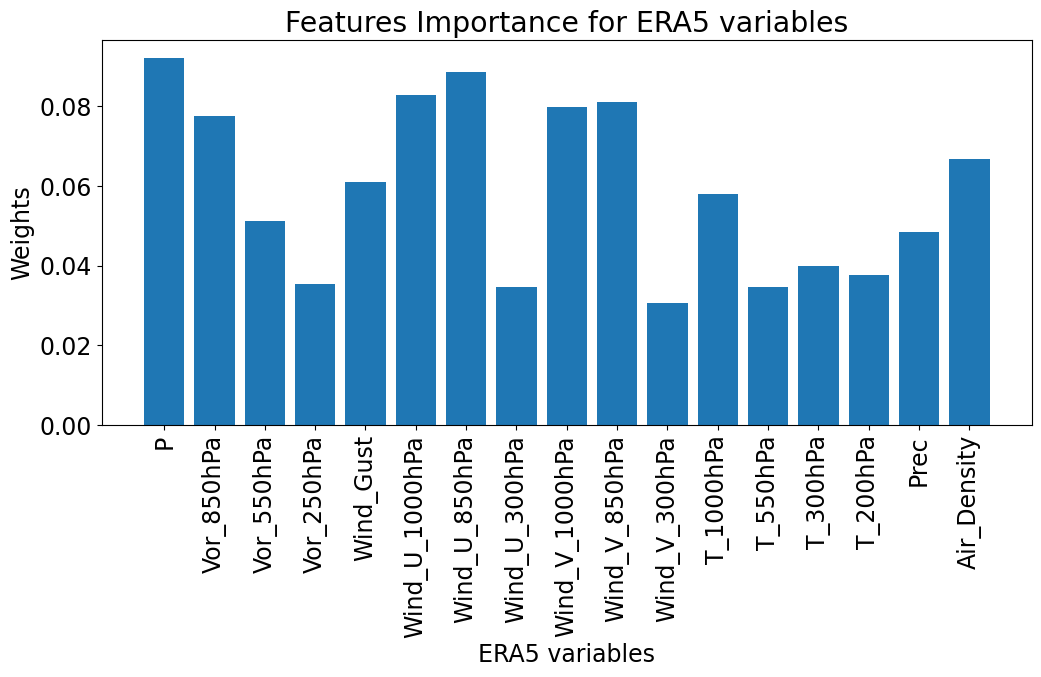

In [53]:
# Extract keys and values from the dictionary
categories = list(meteo_var_dict.keys())
values = list(meteo_var_dict.values())

plt.rcParams.update({'font.size': 17})
# Increase the size of the figure by adjusting the figsize parameter
fig, ax = plt.subplots(figsize=(12, 5))

# Plot the bar chart
ax.bar(categories, values, color=['C0' if val > 0 else 'blue' for val in values])

# Customize the plot
ax.set_xlabel('ERA5 variables')
ax.set_ylabel('Weights')
ax.set_title('Features Importance for ERA5 variables')
# Rotate x-axis labels vertically
ax.set_xticklabels(categories, rotation=90)

plt.show()

In [54]:
meteo_var_dict

{'P': 0.09201928591194297,
 'Vor_850hPa': 0.07749211433344202,
 'Vor_550hPa': 0.051229242524191504,
 'Vor_250hPa': 0.035427101118969545,
 'Wind_Gust': 0.060937236525775235,
 'Wind_U_1000hPa': 0.08291868632796853,
 'Wind_U_850hPa': 0.0885819218374082,
 'Wind_U_300hPa': 0.034716473590218094,
 'Wind_V_1000hPa': 0.07981981580189368,
 'Wind_V_850hPa': 0.08098287535628465,
 'Wind_V_300hPa': 0.030580318683146108,
 'T_1000hPa': 0.05788166772393365,
 'T_550hPa': 0.03474122556871928,
 'T_300hPa': 0.039857391443217274,
 'T_200hPa': 0.03763883964865759,
 'Prec': 0.04839759737760012,
 'Air_Density': 0.06677820622663151}

In [55]:
# Sum U and V component of speed
new_keys = ['P', 'Vor_850hPa', 'Vor_550hPa', 'Vor_250hPa', 'Wind_Gust', 'Wind_1000hPa', 'Wind_850hPa', 'Wind_300hPa', 'T_1000hPa', 'T_550hPa', 'T_300hPa', 'T_200hPa', 'Prec', 'Air_Density']
old_values = list(meteo_var_dict.values())
new_values = []

score_wind_1000hPa = meteo_var_dict['Wind_U_1000hPa'] + meteo_var_dict['Wind_V_1000hPa']
score_wind_850hPa  = meteo_var_dict['Wind_U_850hPa'] + meteo_var_dict['Wind_V_850hPa']
score_wind_300hPa  = meteo_var_dict['Wind_U_300hPa'] + meteo_var_dict['Wind_V_300hPa']

for i in range(5):
  new_values.append(old_values[i])

new_values.append(score_wind_1000hPa)
new_values.append(score_wind_850hPa)
new_values.append(score_wind_300hPa)

for i in range(11, 17):
  new_values.append(old_values[i])


new_meteo_var_dict = dict(zip(new_keys, new_values))
new_meteo_var_dict

{'P': 0.09201928591194297,
 'Vor_850hPa': 0.07749211433344202,
 'Vor_550hPa': 0.051229242524191504,
 'Vor_250hPa': 0.035427101118969545,
 'Wind_Gust': 0.060937236525775235,
 'Wind_1000hPa': 0.1627385021298622,
 'Wind_850hPa': 0.16956479719369286,
 'Wind_300hPa': 0.0652967922733642,
 'T_1000hPa': 0.05788166772393365,
 'T_550hPa': 0.03474122556871928,
 'T_300hPa': 0.039857391443217274,
 'T_200hPa': 0.03763883964865759,
 'Prec': 0.04839759737760012,
 'Air_Density': 0.06677820622663151}

<ipython-input-56-3f8a209c84c2>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(categories, rotation=90)


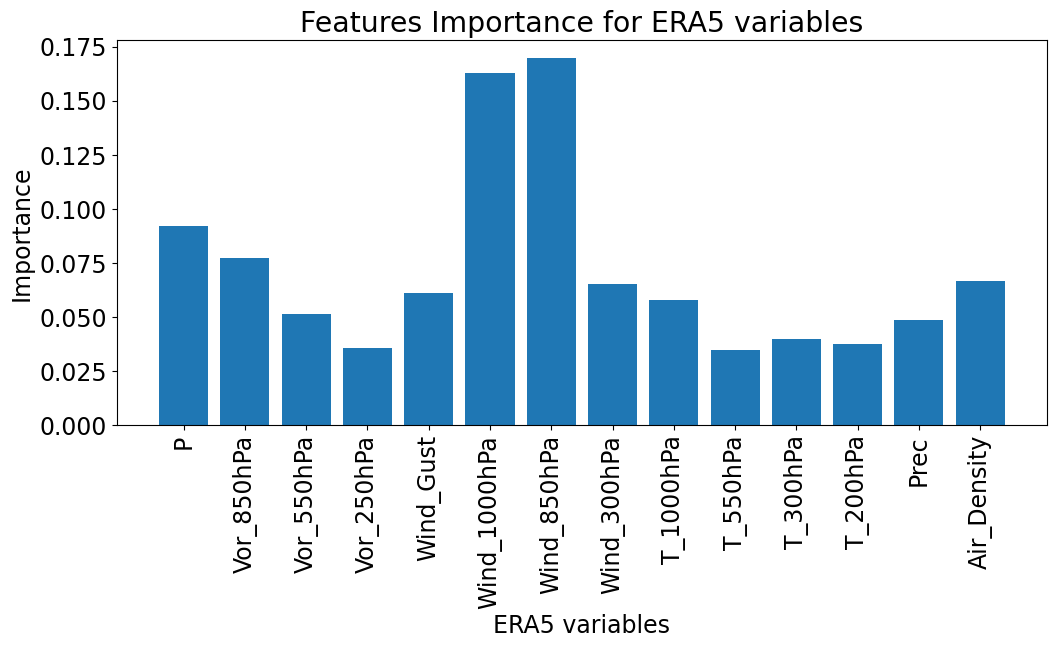

In [56]:
# Extract keys and values from the dictionary
categories = list(new_meteo_var_dict.keys())
values = list(new_meteo_var_dict.values())

# Increase the size of the figure by adjusting the figsize parameter
fig, ax = plt.subplots(figsize=(12, 5))

# Plot the bar chart
ax.bar(categories, values, color=['C0' if val > 0 else 'blue' for val in values])

# Customize the plot
ax.set_xlabel('ERA5 variables')
ax.set_ylabel('Importance')
ax.set_title('Features Importance for ERA5 variables')
# Rotate x-axis labels vertically
ax.set_xticklabels(categories, rotation=90)

plt.show()

In [57]:
# Using SelectFromModel

selector = SelectFromModel(clf, prefit=True)
X_new = selector.transform(X)
support_vector = selector.get_support()
print('New dataset: ', X_new.shape)

print('Variable Selected: ')

old_vars = df_era5_today.columns
num_vars = support_vector.shape[0]
selected_vars = []

for i in range(num_vars):
  if support_vector[i]:
    selected_vars.append(old_vars[i])

print(selected_vars)

New dataset:  (15310, 141)
Variable Selected: 
['P_Mean_Z5', 'P_Mean_Z6', 'P_Std_Z6', 'P_Mean_Z7', 'P_Std_Z7', 'P_Mean_Z8', 'P_Std_Z8', 'P_Mean_Z9', 'P_Mean_Z10', 'P_Std_Z10', 'P_Mean_Z11', 'P_Std_Z11', 'P_Mean_Z12', 'P_Std_Z12', 'P_Mean_Z14', 'P_Std_Z15', 'Vor_850hPa_Mean_Z2', 'Vor_850hPa_Mean_Z3', 'Vor_850hPa_Mean_Z4', 'Vor_850hPa_Std_Z6', 'Vor_850hPa_Mean_Z7', 'Vor_850hPa_Std_Z7', 'Vor_850hPa_Mean_Z8', 'Vor_850hPa_Std_Z8', 'Vor_850hPa_Std_Z9', 'Vor_850hPa_Mean_Z10', 'Vor_850hPa_Std_Z10', 'Vor_850hPa_Mean_Z11', 'Vor_850hPa_Std_Z11', 'Vor_850hPa_Mean_Z12', 'Vor_850hPa_Std_Z12', 'Vor_850hPa_Std_Z14', 'Vor_850hPa_Std_Z15', 'Vor_550hPa_Std_Z6', 'Vor_550hPa_Std_Z7', 'Vor_550hPa_Std_Z8', 'Vor_550hPa_Std_Z9', 'Vor_550hPa_Std_Z10', 'Vor_550hPa_Std_Z11', 'Vor_550hPa_Std_Z12', 'Vor_250hPa_Std_Z7', 'Vor_250hPa_Std_Z8', 'Wind_Gust_Mean_Z6', 'Wind_Gust_Std_Z6', 'Wind_Gust_Mean_Z7', 'Wind_Gust_Std_Z7', 'Wind_Gust_Std_Z8', 'Wind_Gust_Std_Z9', 'Wind_Gust_Mean_Z10', 'Wind_Gust_Std_Z10', 'Wind_Gust_Me

## Mean or Std?

In [58]:
print(feature_importances.shape[0], len(df_era5_today.columns))
feature_names = df_era5_today.columns

mean_score = 0
std_score = 0
for i in range(len(feature_names)):
  if '_Mean_' in feature_names[i]:
    mean_score += feature_importances[i]
  elif '_Std_' in feature_names[i]:
    std_score += feature_importances[i]

print('MEAN SCORE: ', mean_score)
print('STD  SCORE: ', std_score)

544 544
MEAN SCORE:  0.5043840604947515
STD  SCORE:  0.4956159395052488


<ipython-input-59-f6a8fd0b4219>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(categories, rotation=0)


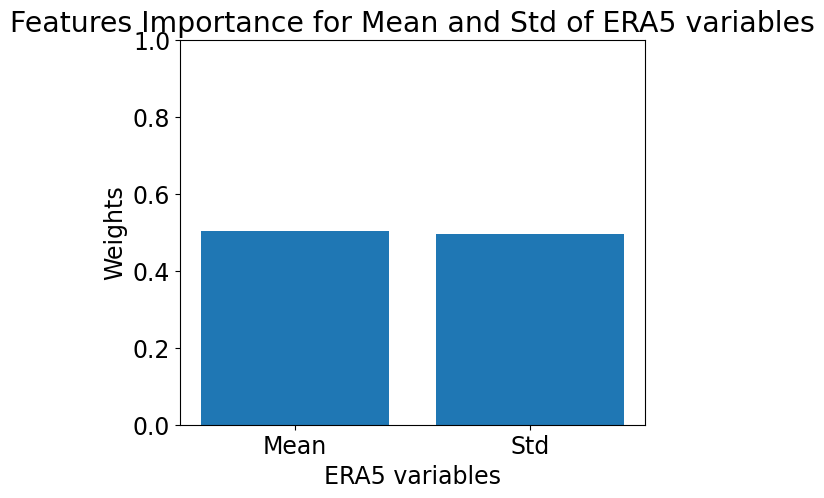

In [59]:
# Extract keys and values from the dictionary
categories = ['Mean', 'Std']
values = [mean_score, std_score]

# Increase the size of the figure by adjusting the figsize parameter
fig, ax = plt.subplots(figsize=(6, 5))

# Plot the bar chart
ax.bar(categories, values, color=['C0' if val > 0 else 'blue' for val in values])

# Customize the plot
ax.set_xlabel('ERA5 variables')
ax.set_ylabel('Weights')
ax.set_title('Features Importance for Mean and Std of ERA5 variables')
# Rotate x-axis labels vertically
ax.set_xticklabels(categories, rotation=0)
# Set y-axis scale from 0 to 1
ax.set_ylim(0, 1)


plt.show()

## Most Relevant zones
Which are the most relevant zones (16 zones)

In [60]:
features = df_era5_today.columns
print(features.shape, feature_importances.shape)

zones_att_list = []
for i in range(16):
  zones_att_list.append('Z{}'.format(i+1))

zones_scores = []
for i in range(0,32,2):
  zones_scores.append(np.sum([feature_importances[i::32], feature_importances[i+1::32]]))

zones_relevance_dict = dict(zip(zones_att_list, zones_scores))

print(zones_relevance_dict)

(544,) (544,)
{'Z1': 0.04630112084851275, 'Z2': 0.046965975970504815, 'Z3': 0.040552667242575564, 'Z4': 0.039067702967804804, 'Z5': 0.051212956407918356, 'Z6': 0.07763823558352088, 'Z7': 0.09846720517175116, 'Z8': 0.08928108426056856, 'Z9': 0.055516767741815694, 'Z10': 0.08886841172025883, 'Z11': 0.10712394948053475, 'Z12': 0.08243760906483218, 'Z13': 0.04093919987874921, 'Z14': 0.048344065785845575, 'Z15': 0.04750532068171084, 'Z16': 0.03977772719309602}


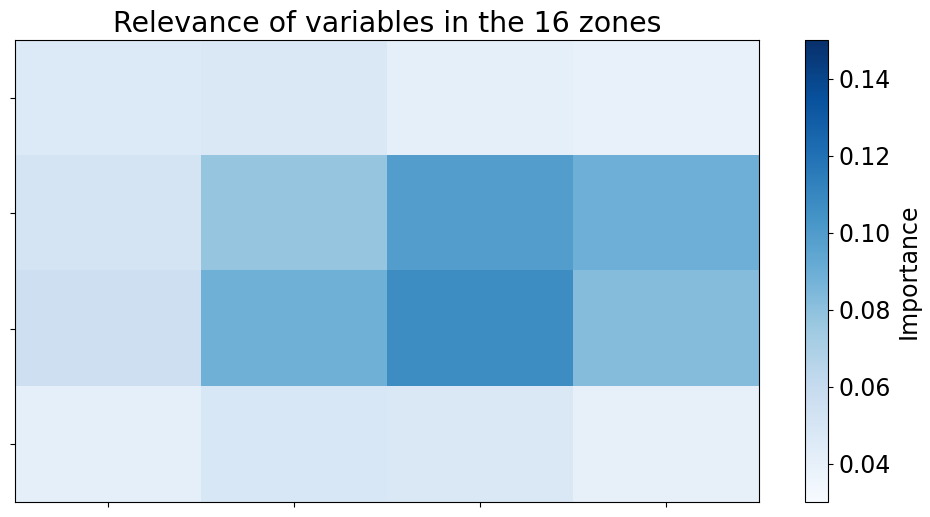

In [61]:
# Extract keys and values from the dictionary
names = list(zones_relevance_dict.keys())
values = list(zones_relevance_dict.values())

# Reshape the 1D list into a 4x4 matrix
heatmap_data = np.array(values).reshape(4, 4)

# Create the heatmap
fig, ax = plt.subplots(figsize=(12, 6))
heatmap = ax.imshow(heatmap_data, cmap='Blues', aspect='auto', vmin=0.03, vmax=0.15)

# Customize the plot
ax.set_xticks(np.arange(len(names)//4))
ax.set_yticks(np.arange(4))
#ax.set_xticklabels([name for i, name in enumerate(names) if i % 4 == 0], rotation=45, ha='right')
#ax.set_yticklabels(names[:4])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('Relevance of variables in the 16 zones')

# Add colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='vertical')
cbar.set_label('Importance')

plt.show()

# Tree-Based model for feature selection of timeseries data

In [62]:
era5_timeseries_features = df_era5.columns
selected_columns = []
today_features = []

# Drop columns of variables that refers to day 0
for feat in era5_timeseries_features:
  if '-0' in feat:
    selected_columns.append(feat)
    today_features.append(feat.replace('-0', ''))
df_era5_timeseries = df_era5.drop(columns=selected_columns)


# Select only columns that are more relevant (considering previous analysis) - 11 variables
selected_meteo_var = ['P_', 'Vor_850hPa_', 'Wind_Gust_', 'Wind_U_1000hPa_', 'Wind_U_850hPa_', 'Wind_U_300hPa_', 'Wind_V_1000hPa_', 'Wind_V_850hPa_', 'Wind_V_300hPa_', 'T_1000hPa_', 'Air_Density_']
era5_timeseries_features = df_era5_timeseries.columns
selected_columns = []

for column in era5_timeseries_features:
  for sel_att in selected_meteo_var:
    if sel_att in column:
      selected_columns.append(column)

df_era5_timeseries = df_era5_timeseries[selected_columns]
print(df_era5_timeseries.columns[0::20*16])

df_era5_timeseries

Index(['P_Mean_Z1-1', 'Vor_850hPa_Mean_Z1-1', 'Wind_Gust_Mean_Z1-1',
       'Wind_U_1000hPa_Mean_Z1-1', 'Wind_U_850hPa_Mean_Z1-1',
       'Wind_U_300hPa_Mean_Z1-1', 'Wind_V_1000hPa_Mean_Z1-1',
       'Wind_V_850hPa_Mean_Z1-1', 'Wind_V_300hPa_Mean_Z1-1',
       'T_1000hPa_Mean_Z1-1', 'Air_Density_Mean_Z1-1'],
      dtype='object')


,P_Mean_Z1-1,P_Mean_Z1-2,P_Mean_Z1-3,P_Mean_Z1-4,P_Mean_Z1-5,P_Mean_Z1-6,P_Mean_Z1-7,P_Mean_Z1-8,P_Mean_Z1-9,P_Mean_Z1-10,...,Air_Density_Std_Z16-1,Air_Density_Std_Z16-2,Air_Density_Std_Z16-3,Air_Density_Std_Z16-4,Air_Density_Std_Z16-5,Air_Density_Std_Z16-6,Air_Density_Std_Z16-7,Air_Density_Std_Z16-8,Air_Density_Std_Z16-9,Air_Density_Std_Z16-10
DATE,,,,,,,,,,,,,,,,,,,,,
1980-02-01,101082.725238,101106.150507,101151.416815,101111.955529,101090.233546,101078.546436,101174.571610,101195.253852,101248.177909,101136.536631,...,0.006678,0.005934,0.006980,0.008098,0.007261,0.008073,0.008458,0.008403,0.008190,0.007908
1980-02-02,101129.517893,101082.725238,101106.150507,101151.416815,101111.955529,101090.233546,101078.546436,101174.571610,101195.253852,101248.177909,...,0.007646,0.006678,0.005934,0.006980,0.008098,0.007261,0.008073,0.008458,0.008403,0.008190
1980-02-03,101145.484832,101129.517893,101082.725238,101106.150507,101151.416815,101111.955529,101090.233546,101078.546436,101174.571610,101195.253852,...,0.008101,0.007646,0.006678,0.005934,0.006980,0.008098,0.007261,0.008073,0.008458,0.008403
1980-02-04,101098.218251,101145.484832,101129.517893,101082.725238,101106.150507,101151.416815,101111.955529,101090.233546,101078.546436,101174.571610,...,0.007434,0.008101,0.007646,0.006678,0.005934,0.006980,0.008098,0.007261,0.008073,0.008458
1980-02-05,101060.819153,101098.218251,101145.484832,101129.517893,101082.725238,101106.150507,101151.416815,101111.955529,101090.233546,101078.546436,...,0.006144,0.007434,0.008101,0.007646,0.006678,0.005934,0.006980,0.008098,0.007261,0.008073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,101198.028907,101107.886727,101086.764893,101201.834068,101272.936280,101322.504401,101265.381370,101279.043146,101274.185730,101169.794719,...,0.008458,0.009978,0.008623,0.008747,0.006054,0.006365,0.006383,0.005746,0.005734,0.007750
2021-12-28,101208.460804,101198.028907,101107.886727,101086.764893,101201.834068,101272.936280,101322.504401,101265.381370,101279.043146,101274.185730,...,0.006263,0.008458,0.009978,0.008623,0.008747,0.006054,0.006365,0.006383,0.005746,0.005734
2021-12-29,101247.951814,101208.460804,101198.028907,101107.886727,101086.764893,101201.834068,101272.936280,101322.504401,101265.381370,101279.043146,...,0.005633,0.006263,0.008458,0.009978,0.008623,0.008747,0.006054,0.006365,0.006383,0.005746


In [63]:
def filter_by_zones(df, zones):
  columns = df.columns
  selected_columns = []
  for col in columns:
    for zone in zones:
      if zone in col:
        selected_columns.append(col)
  return df[selected_columns]


df_filtered_zones = filter_by_zones(df_era5_timeseries, ['_Z6', '_Z7', '_Z8', '_Z10', '_Z11', '_Z12'])
df_filtered_zones

,P_Mean_Z6-1,P_Mean_Z6-2,P_Mean_Z6-3,P_Mean_Z6-4,P_Mean_Z6-5,P_Mean_Z6-6,P_Mean_Z6-7,P_Mean_Z6-8,P_Mean_Z6-9,P_Mean_Z6-10,...,Air_Density_Std_Z12-1,Air_Density_Std_Z12-2,Air_Density_Std_Z12-3,Air_Density_Std_Z12-4,Air_Density_Std_Z12-5,Air_Density_Std_Z12-6,Air_Density_Std_Z12-7,Air_Density_Std_Z12-8,Air_Density_Std_Z12-9,Air_Density_Std_Z12-10
DATE,,,,,,,,,,,,,,,,,,,,,
1980-02-01,100854.216318,100727.761136,100731.080432,100774.812572,100720.828522,100671.814687,100706.554001,100817.759721,101006.504358,101073.051739,...,0.003901,0.004331,0.004536,0.004729,0.004530,0.003421,0.004308,0.004793,0.004998,0.005651
1980-02-02,100957.221037,100854.216318,100727.761136,100731.080432,100774.812572,100720.828522,100671.814687,100706.554001,100817.759721,101006.504358,...,0.003816,0.003901,0.004331,0.004536,0.004729,0.004530,0.003421,0.004308,0.004793,0.004998
1980-02-03,101004.407341,100957.221037,100854.216318,100727.761136,100731.080432,100774.812572,100720.828522,100671.814687,100706.554001,100817.759721,...,0.005195,0.003816,0.003901,0.004331,0.004536,0.004729,0.004530,0.003421,0.004308,0.004793
1980-02-04,100821.384484,101004.407341,100957.221037,100854.216318,100727.761136,100731.080432,100774.812572,100720.828522,100671.814687,100706.554001,...,0.005215,0.005195,0.003816,0.003901,0.004331,0.004536,0.004729,0.004530,0.003421,0.004308
1980-02-05,100863.122198,100821.384484,101004.407341,100957.221037,100854.216318,100727.761136,100731.080432,100774.812572,100720.828522,100671.814687,...,0.004834,0.005215,0.005195,0.003816,0.003901,0.004331,0.004536,0.004729,0.004530,0.003421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,101210.641310,101129.138241,101059.403055,101164.516236,101162.820031,101229.043008,101064.108231,101091.267523,101125.865959,101143.223389,...,0.003538,0.003577,0.004064,0.003845,0.003609,0.004035,0.004349,0.005315,0.006128,0.007000
2021-12-28,101225.780524,101210.641310,101129.138241,101059.403055,101164.516236,101162.820031,101229.043008,101064.108231,101091.267523,101125.865959,...,0.003007,0.003538,0.003577,0.004064,0.003845,0.003609,0.004035,0.004349,0.005315,0.006128
2021-12-29,101139.912903,101225.780524,101210.641310,101129.138241,101059.403055,101164.516236,101162.820031,101229.043008,101064.108231,101091.267523,...,0.003509,0.003007,0.003538,0.003577,0.004064,0.003845,0.003609,0.004035,0.004349,0.005315


In [64]:
X = df_filtered_zones.values

clf = ExtraTreesClassifier(n_estimators=600)
clf = clf.fit(X, y)
feature_importances = clf.feature_importances_

In [65]:
cols = df_filtered_zones.columns
print(feature_importances.shape, cols.shape)
print(cols[0::10])

(1320,) (1320,)
Index(['P_Mean_Z6-1', 'P_Std_Z6-1', 'P_Mean_Z7-1', 'P_Std_Z7-1', 'P_Mean_Z8-1',
       'P_Std_Z8-1', 'P_Mean_Z10-1', 'P_Std_Z10-1', 'P_Mean_Z11-1',
       'P_Std_Z11-1',
       ...
       'Air_Density_Mean_Z7-1', 'Air_Density_Std_Z7-1',
       'Air_Density_Mean_Z8-1', 'Air_Density_Std_Z8-1',
       'Air_Density_Mean_Z10-1', 'Air_Density_Std_Z10-1',
       'Air_Density_Mean_Z11-1', 'Air_Density_Std_Z11-1',
       'Air_Density_Mean_Z12-1', 'Air_Density_Std_Z12-1'],
      dtype='object', length=132)


In [66]:
1*6*11*2

132

In [67]:
# Compute the overall importance of each day in the timeseries
samples_scores_dict = {}
for i in range(10):
  score = np.sum(feature_importances[i::10])
  samples_scores_dict['t-{}'.format(i+1)] = score

print(samples_scores_dict)

{'t-1': 0.21233583485584234, 't-2': 0.16106653883503308, 't-3': 0.11957369887772053, 't-4': 0.09478841173919095, 't-5': 0.07743616775540596, 't-6': 0.07079353826693657, 't-7': 0.06820500356019125, 't-8': 0.06612307619575541, 't-9': 0.06452360284535828, 't-10': 0.06515412706856566}


<ipython-input-68-b41d098175a2>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(categories, rotation=0)


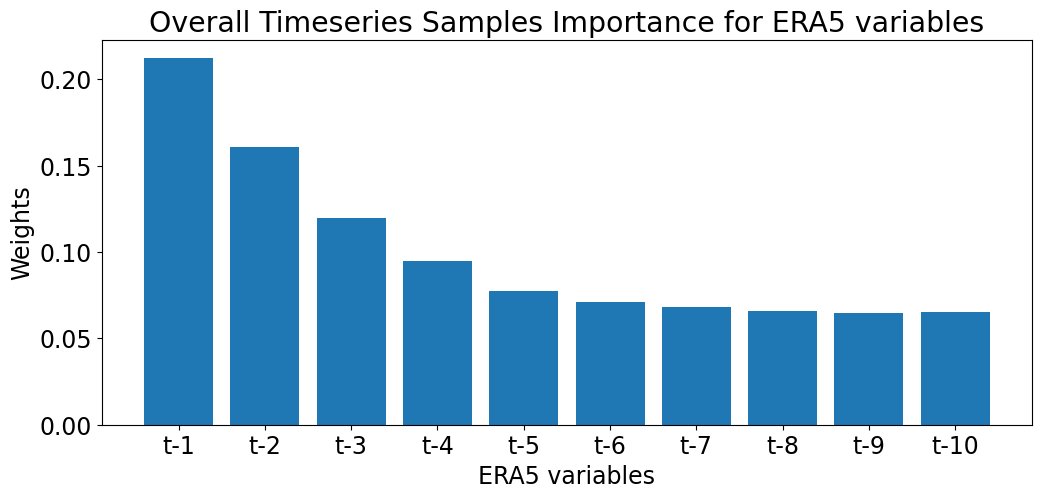

In [68]:
# Extract keys and values from the dictionary
categories = list(samples_scores_dict.keys())
values = list(samples_scores_dict.values())

# Increase the size of the figure by adjusting the figsize parameter
fig, ax = plt.subplots(figsize=(12, 5))

# Plot the bar chart
ax.bar(categories, values, color=['C0' if val > 0 else 'blue' for val in values])

# Customize the plot
ax.set_xlabel('ERA5 variables')
ax.set_ylabel('Weights')
ax.set_title('Overall Timeseries Samples Importance for ERA5 variables')
# Rotate x-axis labels vertically
ax.set_xticklabels(categories, rotation=0)

plt.show()

In [69]:
cols[10:]

Index(['P_Std_Z6-1', 'P_Std_Z6-2', 'P_Std_Z6-3', 'P_Std_Z6-4', 'P_Std_Z6-5',
       'P_Std_Z6-6', 'P_Std_Z6-7', 'P_Std_Z6-8', 'P_Std_Z6-9', 'P_Std_Z6-10',
       ...
       'Air_Density_Std_Z12-1', 'Air_Density_Std_Z12-2',
       'Air_Density_Std_Z12-3', 'Air_Density_Std_Z12-4',
       'Air_Density_Std_Z12-5', 'Air_Density_Std_Z12-6',
       'Air_Density_Std_Z12-7', 'Air_Density_Std_Z12-8',
       'Air_Density_Std_Z12-9', 'Air_Density_Std_Z12-10'],
      dtype='object', length=1310)

In [70]:
7*120 + 240

1080

In [71]:
selected_meteo_var = ['P_', 'Vor_850hPa_', 'Wind_Gust_', 'Wind_U_1000hPa_', 'Wind_U_850hPa_', 'Wind_U_300hPa_', 'Wind_V_1000hPa_', 'Wind_V_850hPa_', 'Wind_V_300hPa_', 'T_1000hPa_', 'Air_Density_']

###########################################################################
# PRESSURE TIMESERIES
press_importance = feature_importances[0:120]
# Compute the overall importance of each day in the timeseries
press_samples_scores_dict = {}
for i in range(10):
  score = np.sum(press_importance[i::10])
  press_samples_scores_dict['t-{}'.format(i+1)] = score

############################################################################
# VOR_850hPa TIMESERIES
vor_importance = feature_importances[120:240]
# Compute the overall importance of each day in the timeseries
vor_samples_scores_dict = {}
for i in range(10):
  score = np.sum(vor_importance[i::10])
  vor_samples_scores_dict['t-{}'.format(i+1)] = score

############################################################################
# WIND_GUST TIMESERIES
gust_importance = feature_importances[240:360]
# Compute the overall importance of each day in the timeseries
gust_samples_scores_dict = {}
for i in range(10):
  score = np.sum(gust_importance[i::10])
  gust_samples_scores_dict['t-{}'.format(i+1)] = score

############################################################################
# T_1000hPa TIMESERIES
t_importance = feature_importances[1080:1200]
# Compute the overall importance of each day in the timeseries
t_samples_scores_dict = {}
for i in range(10):
  score = np.sum(t_importance[i::10])
  t_samples_scores_dict['t-{}'.format(i+1)] = score

############################################################################
# AIR_DENSITY TIMESERIES
air_density_importance = feature_importances[1200:]
# Compute the overall importance of each day in the timeseries
air_density_samples_scores_dict = {}
for i in range(10):
  score = np.sum(air_density_importance[i::10])
  air_density_samples_scores_dict['t-{}'.format(i+1)] = score



print('PRESSURE:    ', press_samples_scores_dict)
print('VOR_850:     ', vor_samples_scores_dict)
print('WIND GUST:   ', gust_samples_scores_dict)
print('T 1000hPa:   ', t_samples_scores_dict)
print('AIR_DENSITY: ', air_density_samples_scores_dict)

PRESSURE:     {'t-1': 0.029638966227713864, 't-2': 0.023717013598343772, 't-3': 0.015280058256674152, 't-4': 0.012498077730776, 't-5': 0.007808301688729984, 't-6': 0.006649545298501097, 't-7': 0.006714978090004142, 't-8': 0.005871420484897272, 't-9': 0.006122089495308837, 't-10': 0.0060283754720132626}
VOR_850:      {'t-1': 0.01986380508438917, 't-2': 0.014996719580805364, 't-3': 0.009202690928361092, 't-4': 0.00700047012203731, 't-5': 0.0061665189610660195, 't-6': 0.005683168101880399, 't-7': 0.005330955681399203, 't-8': 0.005250463602794974, 't-9': 0.005094105158907088, 't-10': 0.005336518000186134}
WIND GUST:    {'t-1': 0.017554012071311513, 't-2': 0.012342819100227954, 't-3': 0.008460412992120515, 't-4': 0.006656384392749383, 't-5': 0.005813015723645703, 't-6': 0.005251615836194685, 't-7': 0.00526018707833136, 't-8': 0.005196570990619587, 't-9': 0.005496011784008646, 't-10': 0.005501172926603657}
T 1000hPa:    {'t-1': 0.009928556527037188, 't-2': 0.010005871090039952, 't-3': 0.0097

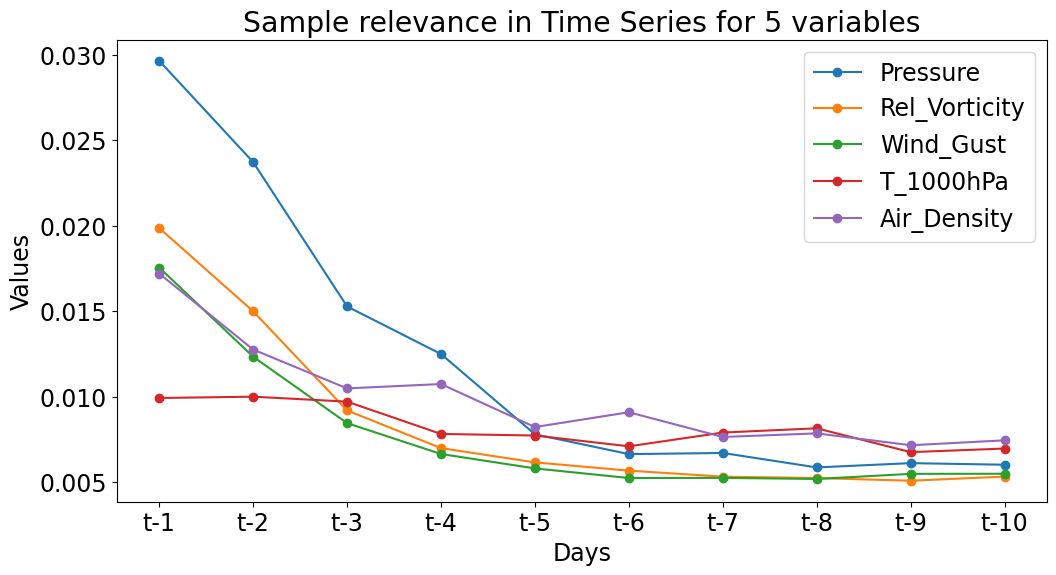

In [72]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

vars = ['Pressure', 'Rel_Vorticity', 'Wind_Gust', 'T_1000hPa', 'Air_Density']
dics = [press_samples_scores_dict, vor_samples_scores_dict, gust_samples_scores_dict, t_samples_scores_dict, air_density_samples_scores_dict]
# Plot lines for each time series
for i in range(5):
    ax.plot(list(dics[i].keys()), list(dics[i].values()), label=vars[i], marker='o')

# Customize the plot
ax.set_xlabel('Days')
ax.set_ylabel('Values')
ax.set_title('Sample relevance in Time Series for 5 variables')
ax.legend()

plt.show()

# Tree-Based model for feature selection on Global and Local Drivers

In [73]:
df_mjo_enso

,RMM1-1,RMM1-2,RMM1-3,RMM1-4,RMM1-5,RMM1-6,RMM1-7,RMM1-8,RMM1-9,RMM1-10,...,indocE-21,indocE-22,indocE-23,indocE-24,indocE-25,indocE-26,indocE-27,indocE-28,indocE-29,indocE-30
DATE,,,,,,,,,,,,,,,,,,,,,
1980-02-01,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,0.479205,0.484783,0.492725,...,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311,0.527535,0.536084,0.540251
1980-02-02,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,0.479205,0.484783,...,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311,0.527535,0.536084
1980-02-03,0.446730,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,0.479205,...,0.564371,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311,0.527535
1980-02-04,0.477843,0.446730,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,...,0.562821,0.564371,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311
1980-02-05,0.482835,0.477843,0.446730,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,...,0.557513,0.562821,0.564371,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.456721,0.459083,0.487810,0.506327,0.522359,0.524730,0.508447,0.536899,0.574846,0.597357,...,0.585440,0.580454,0.595150,0.576959,0.601620,0.613510,0.615770,0.612231,0.609712,0.605784
2021-12-28,0.430960,0.456721,0.459083,0.487810,0.506327,0.522359,0.524730,0.508447,0.536899,0.574846,...,0.613950,0.585440,0.580454,0.595150,0.576959,0.601620,0.613510,0.615770,0.612231,0.609712
2021-12-29,0.412768,0.430960,0.456721,0.459083,0.487810,0.506327,0.522359,0.524730,0.508447,0.536899,...,0.606413,0.613950,0.585440,0.580454,0.595150,0.576959,0.601620,0.613510,0.615770,0.612231


In [74]:
df_era5

,P_Mean_Z1-0,P_Mean_Z1-1,P_Mean_Z1-2,P_Mean_Z1-3,P_Mean_Z1-4,P_Mean_Z1-5,P_Mean_Z1-6,P_Mean_Z1-7,P_Mean_Z1-8,P_Mean_Z1-9,...,Air_Density_Std_Z16-1,Air_Density_Std_Z16-2,Air_Density_Std_Z16-3,Air_Density_Std_Z16-4,Air_Density_Std_Z16-5,Air_Density_Std_Z16-6,Air_Density_Std_Z16-7,Air_Density_Std_Z16-8,Air_Density_Std_Z16-9,Air_Density_Std_Z16-10
DATE,,,,,,,,,,,,,,,,,,,,,
1980-02-01,101129.517893,101082.725238,101106.150507,101151.416815,101111.955529,101090.233546,101078.546436,101174.571610,101195.253852,101248.177909,...,0.006678,0.005934,0.006980,0.008098,0.007261,0.008073,0.008458,0.008403,0.008190,0.007908
1980-02-02,101145.484832,101129.517893,101082.725238,101106.150507,101151.416815,101111.955529,101090.233546,101078.546436,101174.571610,101195.253852,...,0.007646,0.006678,0.005934,0.006980,0.008098,0.007261,0.008073,0.008458,0.008403,0.008190
1980-02-03,101098.218251,101145.484832,101129.517893,101082.725238,101106.150507,101151.416815,101111.955529,101090.233546,101078.546436,101174.571610,...,0.008101,0.007646,0.006678,0.005934,0.006980,0.008098,0.007261,0.008073,0.008458,0.008403
1980-02-04,101060.819153,101098.218251,101145.484832,101129.517893,101082.725238,101106.150507,101151.416815,101111.955529,101090.233546,101078.546436,...,0.007434,0.008101,0.007646,0.006678,0.005934,0.006980,0.008098,0.007261,0.008073,0.008458
1980-02-05,100978.341555,101060.819153,101098.218251,101145.484832,101129.517893,101082.725238,101106.150507,101151.416815,101111.955529,101090.233546,...,0.006144,0.007434,0.008101,0.007646,0.006678,0.005934,0.006980,0.008098,0.007261,0.008073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,101208.460804,101198.028907,101107.886727,101086.764893,101201.834068,101272.936280,101322.504401,101265.381370,101279.043146,101274.185730,...,0.008458,0.009978,0.008623,0.008747,0.006054,0.006365,0.006383,0.005746,0.005734,0.007750
2021-12-28,101247.951814,101208.460804,101198.028907,101107.886727,101086.764893,101201.834068,101272.936280,101322.504401,101265.381370,101279.043146,...,0.006263,0.008458,0.009978,0.008623,0.008747,0.006054,0.006365,0.006383,0.005746,0.005734
2021-12-29,101167.736893,101247.951814,101208.460804,101198.028907,101107.886727,101086.764893,101201.834068,101272.936280,101322.504401,101265.381370,...,0.005633,0.006263,0.008458,0.009978,0.008623,0.008747,0.006054,0.006365,0.006383,0.005746


In [75]:
df_global_local = pd.concat([df_era5, df_mjo_enso], axis=1)
df_global_local

,P_Mean_Z1-0,P_Mean_Z1-1,P_Mean_Z1-2,P_Mean_Z1-3,P_Mean_Z1-4,P_Mean_Z1-5,P_Mean_Z1-6,P_Mean_Z1-7,P_Mean_Z1-8,P_Mean_Z1-9,...,indocE-21,indocE-22,indocE-23,indocE-24,indocE-25,indocE-26,indocE-27,indocE-28,indocE-29,indocE-30
DATE,,,,,,,,,,,,,,,,,,,,,
1980-02-01,101129.517893,101082.725238,101106.150507,101151.416815,101111.955529,101090.233546,101078.546436,101174.571610,101195.253852,101248.177909,...,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311,0.527535,0.536084,0.540251
1980-02-02,101145.484832,101129.517893,101082.725238,101106.150507,101151.416815,101111.955529,101090.233546,101078.546436,101174.571610,101195.253852,...,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311,0.527535,0.536084
1980-02-03,101098.218251,101145.484832,101129.517893,101082.725238,101106.150507,101151.416815,101111.955529,101090.233546,101078.546436,101174.571610,...,0.564371,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311,0.527535
1980-02-04,101060.819153,101098.218251,101145.484832,101129.517893,101082.725238,101106.150507,101151.416815,101111.955529,101090.233546,101078.546436,...,0.562821,0.564371,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311
1980-02-05,100978.341555,101060.819153,101098.218251,101145.484832,101129.517893,101082.725238,101106.150507,101151.416815,101111.955529,101090.233546,...,0.557513,0.562821,0.564371,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,101208.460804,101198.028907,101107.886727,101086.764893,101201.834068,101272.936280,101322.504401,101265.381370,101279.043146,101274.185730,...,0.585440,0.580454,0.595150,0.576959,0.601620,0.613510,0.615770,0.612231,0.609712,0.605784
2021-12-28,101247.951814,101208.460804,101198.028907,101107.886727,101086.764893,101201.834068,101272.936280,101322.504401,101265.381370,101279.043146,...,0.613950,0.585440,0.580454,0.595150,0.576959,0.601620,0.613510,0.615770,0.612231,0.609712
2021-12-29,101167.736893,101247.951814,101208.460804,101198.028907,101107.886727,101086.764893,101201.834068,101272.936280,101322.504401,101265.381370,...,0.606413,0.613950,0.585440,0.580454,0.595150,0.576959,0.601620,0.613510,0.615770,0.612231


In [76]:
df_target

DATE
1980-02-01    1
1980-02-02    1
1980-02-03    1
1980-02-04    1
1980-02-05    1
             ..
2021-12-27    0
2021-12-28    0
2021-12-29    0
2021-12-30    0
2021-12-31    0
Name: Label, Length: 15310, dtype: int64

In [77]:
X = df_global_local.values
y = df_target.values

clf = ExtraTreesClassifier(n_estimators=600)
clf = clf.fit(X, y)
feature_importances = clf.feature_importances_

In [82]:
features = df_global_local.columns
print(features)
print(feature_importances)

global_score=0
local_score=0

for i in range(len(features)):
  if features[i] in df_mjo_enso.columns:
    global_score += feature_importances[i]
  elif features[i] in df_era5.columns:
    local_score += feature_importances[i]


print(global_score)
print(local_score)

Index(['P_Mean_Z1-0', 'P_Mean_Z1-1', 'P_Mean_Z1-2', 'P_Mean_Z1-3',
       'P_Mean_Z1-4', 'P_Mean_Z1-5', 'P_Mean_Z1-6', 'P_Mean_Z1-7',
       'P_Mean_Z1-8', 'P_Mean_Z1-9',
       ...
       'indocE-21', 'indocE-22', 'indocE-23', 'indocE-24', 'indocE-25',
       'indocE-26', 'indocE-27', 'indocE-28', 'indocE-29', 'indocE-30'],
      dtype='object', length=6958)
[1.48546779e-04 1.19372015e-04 9.88922497e-05 ... 8.85357950e-05
 7.95669908e-05 9.53730543e-05]
0.031959722567321255
0.9680402774326794


<ipython-input-83-923ed631b957>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(categories, rotation=0)


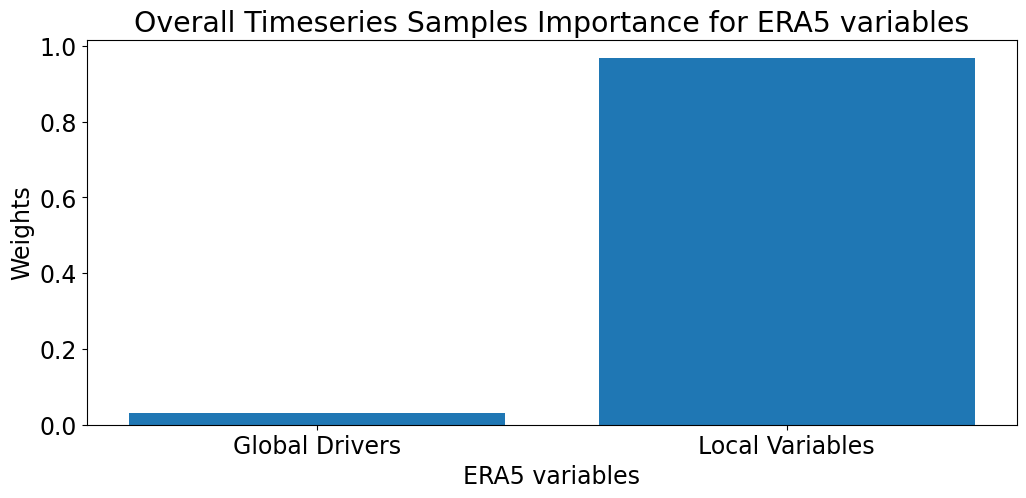

In [83]:
# Extract keys and values from the dictionary
categories = ['Global Drivers', 'Local Variables']
values = [global_score, local_score]

# Increase the size of the figure by adjusting the figsize parameter
fig, ax = plt.subplots(figsize=(12, 5))

# Plot the bar chart
ax.bar(categories, values, color=['C0' if val > 0 else 'blue' for val in values])

# Customize the plot
ax.set_xlabel('ERA5 variables')
ax.set_ylabel('Weights')
ax.set_title('Overall Timeseries Samples Importance for ERA5 variables')
# Rotate x-axis labels vertically
ax.set_xticklabels(categories, rotation=0)

plt.show()